This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1389
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

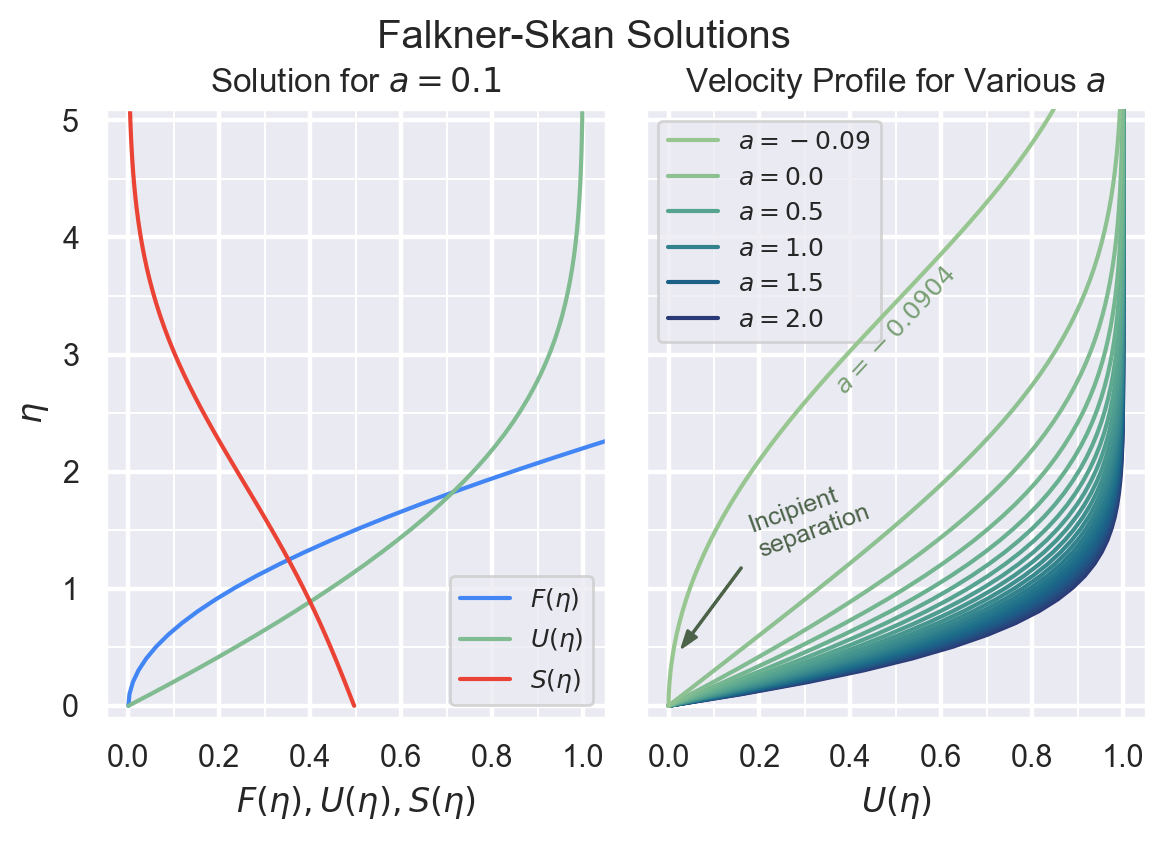

In [82]:
from aerosandbox.tools.pretty_plots import plt, sns, mpl, show_plot, set_ticks, palettes

import aerosandbox as asb
import aerosandbox.numpy as np

opti = asb.Opti()  # Initialize an optimization/analysis environment

a = opti.parameter(0.1)

eta = np.linspace(0, 10, 100)  # Discretize eta from 0 to 10.

F = opti.variable(init_guess=eta + 10 / 3 * (1 - eta / 10) ** 3)

U = opti.derivative_of(F, with_respect_to=eta,
                       derivative_init_guess=1 - (1 - eta / 10) ** 2
                       )
S = opti.derivative_of(U, with_respect_to=eta,
                       derivative_init_guess=0.2 * (1 - eta / 10)
                       )

opti.constrain_derivative(
    variable=S,
    with_respect_to=eta,
    derivative=-(1 + a) / 2 * F * S - a * (1 - U ** 2)
)

opti.subject_to([
    F[0] == 0,
    U[0] == 0,
    U[-1] == 1,
])

sol = opti.solve(verbose=False)

# ----- Plotting below


a_values = np.concatenate([
    np.array([-0.09044]),
    np.arange(0, 2.1, 0.1)
])
cmap = plt.cm.Reds_r
# cmap = sns.color_palette("Blues_r", as_cmap=True)
cmap = sns.color_palette("crest", as_cmap=True)


def color_from_a(a):
    s = (a + 0.09044) / 2.09044
    s = 0.9 * s + 0.05
    return cmap(s)

def darken(color, frac):
    return (1-frac) * np.array(color) + frac*np.array([0, 0, 0, 1])

fig, ax = plt.subplots(1, 2, figsize=(6, 4.5), dpi=200, sharey=True)

plt.sca(ax[0])
colors = [
    palettes["categorical"][0],
    color_from_a(opti.value(a)),
    palettes["categorical"][1],
]
for i, var in enumerate(["F", "U", "S"]):
    plt.plot(
        sol.value(eval(var)),
        eta,
        color=colors[i],
        label=fr"${var}(\eta)$"
    )
plt.xlim(-0.05, 1.05)
plt.ylim(-0.1, 5.1)
set_ticks(0.2, 0.1, 1, 0.5)
plt.title(rf"Solution for $a = {opti.value(a)}$")
plt.xlabel(r"$F(\eta), U(\eta), S(\eta)$")
plt.ylabel(r"$\eta$")
plt.legend(fontsize=9)

plt.sca(ax[1])

colors = plt.cm.rainbow(np.linspace(1, 0, len(a_values)))
for i, value in enumerate(a_values):
    opti.set_value(a, value)
    sol = opti.solve(verbose=False)

    label = None
    if i == 0:
        label = rf"$a = {sol.value(a):.2f}$"

        labelx = 0.5
        plt.text(
            labelx,
            asb.InterpolatedModel(sol.value(U), eta)(labelx) - 0.25,
            rf"$a = {value:.3}$",
            ha="center",
            va="center",
            color=darken(color_from_a(value), 0.2),
            fontsize=9,
            rotation=47
        )
        plt.annotate(
            text="Incipient\nseparation",
            fontsize=9,
            va="center",
            xy=(0.03, 0.5),
            xytext=(0.17, 1.6),
            xycoords="data",
            color =darken(color_from_a(value), 0.5),
            rotation=20,
            arrowprops={
                "color"     : darken(color_from_a(value), 0.5),
                "width"     : 0.25,
                "headwidth" : 4,
                "headlength": 6,
            }
        )

    elif (i - 1) % 5 == 0:
        label = rf"$a = {sol.value(a):.1f}$"

    plt.plot(
        sol.value(U),
        eta,
        label=label,
        color=color_from_a(value),
        zorder=3 + len(a_values) - i
    )
plt.title(rf"Velocity Profile for Various $a$")
plt.xlabel(rf"$U(\eta)$")
set_ticks(x_major=0.2, x_minor=0.1)
plt.xlim(-0.05, 1.05)
plt.legend(fontsize=9)

plt.suptitle("Falkner-Skan Solutions", y=0.93)

show_plot(
    legend=False,
    show=False
)
# plt.savefig(r"C:\Users\User\Dropbox (MIT)\School\Grad School\2021 Spring\Thesis\TeX\figures\fs.pgf")
plt.show()

Nice!

## Plotting Families of the ODE

For kicks, we can also plot $U(\eta)$ for a bunch of different values of $a$:

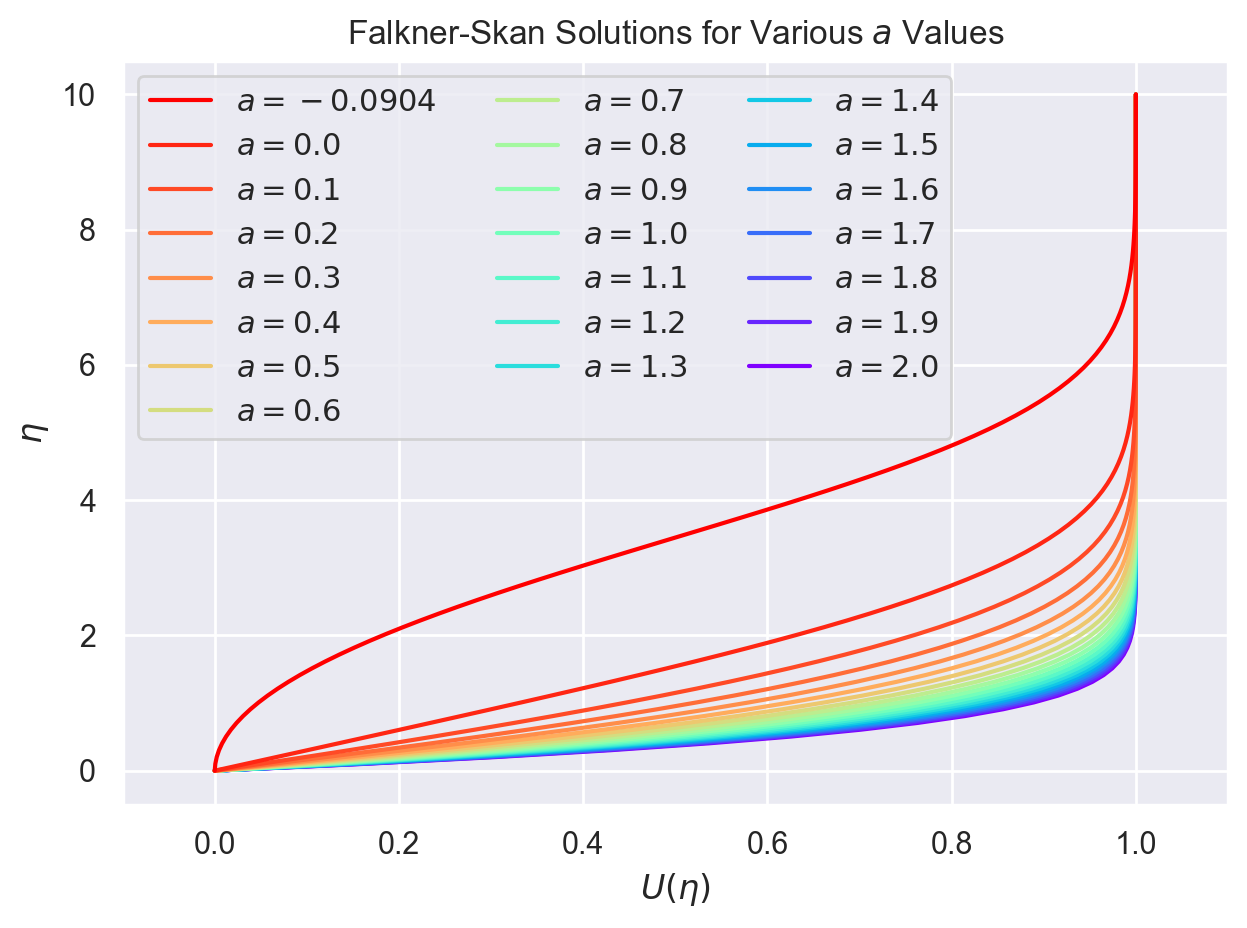

In [3]:
a_values = [-0.09044] + list(np.arange(0, 2.1, 0.1))

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
colors = plt.cm.rainbow(np.linspace(1, 0, len(a_values)))

for i, value in enumerate(a_values):
    opti.set_value(a, value)
    sol = opti.solve(verbose=False)

    plt.plot(
        sol.value(U),
        eta,
        label=rf"$a = {sol.value(a):.1f}$" if i != 0 else rf"$a = {sol.value(a):.4f}$",
        color=colors[i],
        zorder=3 + len(a_values) - i
    )

plt.xlim(-0.1, 1.1)
plt.xlabel(r"$U(\eta)$")
plt.ylabel(r"$\eta$")
plt.title(r"Falkner-Skan Solutions for Various $a$ Values")
plt.tight_layout()
plt.legend(ncol=3)
plt.show()

Cool. So far, this has all been pretty normal. But, let's change it up a bit.

## Doing Inverse Analysis

Take a look at our solution above for $a \approx -0.0904$. Something interesting is happening here - this is an incipient separation flow. We can tell because the nondimensional shear $S(\eta) = dU/d\eta$ at the wall ($\eta = 0$) is going to zero.

But our value of $-0.0904$ was just a guess, found by trial and error. Suppose now we want to ask the following question: at what exact value of $a$ does the flow separate, as indicated by the wall shear $S(0)$ going exactly to zero?

If we had solved this ODE with traditional methods, this would be a big pain - we would need to add $a$ as an unknown and define another residual equation after differentiating with respect to $a$ before resolving.

One might suggest trial and error instead - why not guess a series of values of $a$ and pick the best one, or do something clever by post-processing the solve? The problem is that for $a < -0.0904$ no solution exists, so trial and error is really tedious and difficult. This is common - often the forward problem is well-posed but the inverse problem is not. So, we need to get a bit clever:

Here, we can solve the inverse problem super easily just by changing $a$ from a parameter to a variable and adding "zero wall shear" as an additional constraint:

In [4]:
opti = asb.Opti()  # Initialize an optimization/analysis environment

a = opti.variable(init_guess=0)  # `a` is a variable now, initialized to a guess of 0 (the Blasius solution)

eta = np.linspace(0, 10, 100)  # Discretize eta from 0 to 10.

F = opti.variable(  # Create a variable F that represents some function F(eta)
    init_guess=eta + 10 / 3 * (1 - eta / 10) ** 3
)
U = opti.derivative_of(  # Create a variable U that represents a derivative of F(eta) with respect to eta.
    variable=F,
    with_respect_to=eta,
    derivative_init_guess=1 - (1 - eta / 10) ** 2
)
S = opti.derivative_of(  # Create a variable S that represents a derviative of U(eta) with respect to eta.
    variable=U,
    with_respect_to=eta,
    derivative_init_guess=0.2 * (1 - eta / 10)
)

opti.constrain_derivative(
    variable=S,
    with_respect_to=eta,
    derivative=-(1 + a) / 2 * F * S - a * (1 - U ** 2)
)
opti.subject_to([
    F[0] == 0,
    U[0] == 0,
    U[-1] == 1,
    S[0] == 0,  # We simply constrain the wall shear to be exactly 0.
])

NameError: name 'n_points' is not defined

Then, we solve again and print our answer for $a$:

In [ ]:
sol = opti.solve(verbose=False)

print(f"Value of `a` at incipient separation: {sol.value(a)}")

So, we can get the value of $a$ at incipient separation without any kind of manual fussing with residual Jacobians - it's all abstracted for us.

This type of solve is called the *inverse solution*, and it comes up **all the time** in engineering.

Another example of the inverse problem: we might analyze an airfoil at an angle of attack of 5 degrees and find that it has a lift coefficient of 0.6. Suppose then that we want to find the angle of attack that corresponds to a lift coefficient of 0.5 - in essense, *go backwards* from lift coefficient to angle of attack.

Solving the inverse problem is often quite tedious without the abstracted approach used here, but it's easily implemented in AeroSandbox.